In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    rates = tf.placeholder(tf.float32, [None], name='rates')
    return states, actions, targetQs, rates

In [4]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [5]:
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [6]:
def model_loss(action_size, hidden_size, states, actions, targetQs, rates):
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    gQs = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    rates = tf.reshape(rates, shape=[-1, 1])
    gloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                   labels=rates)) # 0-1
    targetQs = tf.reshape(targetQs, shape=[-1, 1])
    gloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                    labels=tf.nn.sigmoid(targetQs))) # 0-1
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    dQs = discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, reuse=True)
    dloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                   labels=rates)) # 0-1
    dloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                    labels=tf.nn.sigmoid(targetQs))) # 0-1
    dloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                    labels=tf.zeros_like(targetQs))) # 0-1
    glossQ = tf.reduce_mean(tf.square(gQs - targetQs)) # DQN
    dlossQ = tf.reduce_mean(tf.square(dQs - targetQs)) # DQN
    return actions_logits, gQs, gloss, dloss, glossQ, dlossQ

In [7]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, g_learning_rate, d_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(g_learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(d_learning_rate).minimize(d_loss, var_list=d_vars)
    return g_opt, d_opt

In [8]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, g_learning_rate, d_learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.rates = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_loss, self.g_lossQ, self.d_lossQ = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, targetQs=self.targetQs, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss,
                                           g_learning_rate=g_learning_rate, 
                                           d_learning_rate=d_learning_rate)

In [9]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch
        self.rates = deque(maxlen=max_size) # rates
#     def sample(self, batch_size):
#         idx = np.random.choice(np.arange(len(self.buffer)), # ==  self.rates
#                                size=batch_size, 
#                                replace=False)
#         return [self.buffer[ii] for ii in idx], [self.rates[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [10]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [11]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
g_learning_rate = 1e-4         # Q-network learning rate
d_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size: 200/500 a successfull episode size
gamma = 0.99                   # future reward discount

In [12]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size,
              g_learning_rate=g_learning_rate, d_learning_rate=d_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [13]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done)])
    memory.rates.append(-1) # empty
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        state = env.reset()
        rate = total_reward/500
        total_reward = 0 # reset
        for idx in range(num_step): # episode length
            if memory.rates[-1-idx] == -1:
                memory.rates[-1-idx] = rate
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [14]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], []
gloss_list, dloss_list = [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window

    # Training episodes/epochs
    for ep in range(1111*3):
        total_reward = 0 # each episode
        gloss_batch, dloss_batch, glossQ_batch, dlossQ_batch= [], [], [], []
        state = env.reset() # each episode
        num_step = 0 # each episode

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done)])
            memory.rates.append(-1) # empty
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            
            # Rating the memory
            if done is True:
                rate = total_reward/500 # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.rates[-1-idx] == -1: # double-check the landmark/marked indexes
                        memory.rates[-1-idx] = rate # rate the trajectory/data
                        
            # Training with the maxrated minibatch
            batch = memory.buffer
            percentage = 0.9
            #for idx in range(memory_size// batch_size):
            idx_arr = np.arange(memory_size// batch_size)
            idx = np.random.choice(idx_arr)
            states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rates = np.array(memory.rates)[idx*batch_size:(idx+1)*batch_size]
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            states = states[rates >= (np.max(rates)*percentage)]
            actions = actions[rates >= (np.max(rates)*percentage)]
            next_states = next_states[rates >= (np.max(rates)*percentage)]
            rewards = rewards[rates >= (np.max(rates)*percentage)]
            dones = dones[rates >= (np.max(rates)*percentage)]
            rates = rates[rates >= (np.max(rates)*percentage)]
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            nextQs_logits = sess.run(model.Qs_logits, feed_dict = {model.states: next_states})
            #nextQs = np.max(nextQs_logits, axis=1) * (1-dones) # DQN
            nextQs = nextQs_logits.reshape([-1]) * (1-dones) # DPG
            targetQs = rewards + (gamma * nextQs)
            dloss, glossQ, dlossQ, _ = sess.run([model.d_loss, model.g_lossQ, model.d_lossQ, 
                                                 model.d_opt], #, model.d_optQ
                                                feed_dict = {model.states: states, 
                                                             model.actions: actions,
                                                             model.targetQs: targetQs, 
                                                             model.rates: rates})
            gloss, _ = sess.run([model.g_loss, model.g_opt], feed_dict = {model.states: states, 
                                                                          model.actions: actions,
                                                                          model.targetQs: targetQs, 
                                                                          model.rates: rates})
            gloss_batch.append(gloss)
            dloss_batch.append(dloss)
            glossQ_batch.append(glossQ)
            dlossQ_batch.append(dlossQ)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(np.mean(gloss_batch)),
              'dloss:{:.4f}'.format(np.mean(dloss_batch)),
              'glossQ:{:.4f}'.format(np.mean(glossQ_batch)),
              'dlossQ:{:.4f}'.format(np.mean(dlossQ_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        gloss_list.append([ep, np.mean(gloss_batch)])
        dloss_list.append([ep, np.mean(dloss_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:14.0000 R:14.0000 rate:0.0280 gloss:1.3773 dloss:2.0290 glossQ:1.0049 dlossQ:1.4560 exploreP:0.9986
Episode:1 meanR:20.0000 R:26.0000 rate:0.0520 gloss:1.3761 dloss:2.0240 glossQ:1.0070 dlossQ:1.4783 exploreP:0.9960
Episode:2 meanR:26.6667 R:40.0000 rate:0.0800 gloss:1.3734 dloss:2.0108 glossQ:1.0080 dlossQ:1.4470 exploreP:0.9921
Episode:3 meanR:24.0000 R:16.0000 rate:0.0320 gloss:1.3694 dloss:1.9894 glossQ:1.0130 dlossQ:1.4114 exploreP:0.9905
Episode:4 meanR:25.4000 R:31.0000 rate:0.0620 gloss:1.3688 dloss:1.9948 glossQ:1.0105 dlossQ:1.4694 exploreP:0.9875
Episode:5 meanR:23.1667 R:12.0000 rate:0.0240 gloss:1.3667 dloss:1.9856 glossQ:1.0092 dlossQ:1.4783 exploreP:0.9863
Episode:6 meanR:22.0000 R:15.0000 rate:0.0300 gloss:1.3654 dloss:1.9845 glossQ:1.0099 dlossQ:1.5087 exploreP:0.9849
Episode:7 meanR:21.0000 R:14.0000 rate:0.0280 gloss:1.3656 dloss:1.9802 glossQ:1.0116 dlossQ:1.4943 exploreP:0.9835
Episode:8 meanR:20.1111 R:13.0000 rate:0.0260 gloss:1.3629 dloss:1.9619 

Episode:71 meanR:22.6250 R:11.0000 rate:0.0220 gloss:1.2489 dloss:1.5575 glossQ:1.1235 dlossQ:1.3132 exploreP:0.8512
Episode:72 meanR:22.8219 R:37.0000 rate:0.0740 gloss:1.2566 dloss:1.5796 glossQ:1.1544 dlossQ:1.3927 exploreP:0.8481
Episode:73 meanR:22.8514 R:25.0000 rate:0.0500 gloss:1.2557 dloss:1.5686 glossQ:1.1127 dlossQ:1.2763 exploreP:0.8460
Episode:74 meanR:22.7333 R:14.0000 rate:0.0280 gloss:1.2463 dloss:1.5476 glossQ:1.1035 dlossQ:1.2649 exploreP:0.8448
Episode:75 meanR:22.6711 R:18.0000 rate:0.0360 gloss:1.2434 dloss:1.5453 glossQ:1.1188 dlossQ:1.2748 exploreP:0.8433
Episode:76 meanR:22.5844 R:16.0000 rate:0.0320 gloss:1.2537 dloss:1.5504 glossQ:1.1166 dlossQ:1.2574 exploreP:0.8420
Episode:77 meanR:23.0641 R:60.0000 rate:0.1200 gloss:1.2380 dloss:1.5274 glossQ:1.1484 dlossQ:1.2861 exploreP:0.8370
Episode:78 meanR:23.0886 R:25.0000 rate:0.0500 gloss:1.2328 dloss:1.5179 glossQ:1.1470 dlossQ:1.2621 exploreP:0.8349
Episode:79 meanR:23.1000 R:24.0000 rate:0.0480 gloss:1.2329 dlos

Episode:141 meanR:20.4000 R:21.0000 rate:0.0420 gloss:1.1461 dloss:1.3470 glossQ:1.1517 dlossQ:1.2588 exploreP:0.7450
Episode:142 meanR:20.3400 R:12.0000 rate:0.0240 gloss:1.1920 dloss:1.3930 glossQ:1.1216 dlossQ:1.2125 exploreP:0.7441
Episode:143 meanR:20.1200 R:16.0000 rate:0.0320 gloss:1.1644 dloss:1.3658 glossQ:1.1445 dlossQ:1.2501 exploreP:0.7429
Episode:144 meanR:20.1500 R:18.0000 rate:0.0360 gloss:1.1750 dloss:1.3844 glossQ:1.2592 dlossQ:1.3948 exploreP:0.7416
Episode:145 meanR:20.1300 R:9.0000 rate:0.0180 gloss:1.1338 dloss:1.3344 glossQ:1.1735 dlossQ:1.3110 exploreP:0.7409
Episode:146 meanR:19.8800 R:13.0000 rate:0.0260 gloss:1.1509 dloss:1.3509 glossQ:1.1427 dlossQ:1.2438 exploreP:0.7400
Episode:147 meanR:20.2000 R:50.0000 rate:0.1000 gloss:1.1608 dloss:1.3620 glossQ:1.1372 dlossQ:1.2568 exploreP:0.7363
Episode:148 meanR:19.6500 R:15.0000 rate:0.0300 gloss:1.1886 dloss:1.3912 glossQ:1.1405 dlossQ:1.2522 exploreP:0.7352
Episode:149 meanR:19.5800 R:11.0000 rate:0.0220 gloss:1.1

Episode:211 meanR:14.8500 R:13.0000 rate:0.0260 gloss:1.1143 dloss:1.2876 glossQ:1.1795 dlossQ:1.1887 exploreP:0.6724
Episode:212 meanR:14.8600 R:13.0000 rate:0.0260 gloss:1.1469 dloss:1.3226 glossQ:1.1259 dlossQ:1.1307 exploreP:0.6716
Episode:213 meanR:14.8600 R:10.0000 rate:0.0200 gloss:1.1299 dloss:1.3037 glossQ:1.1369 dlossQ:1.1447 exploreP:0.6709
Episode:214 meanR:14.8500 R:11.0000 rate:0.0220 gloss:1.1419 dloss:1.3147 glossQ:1.1426 dlossQ:1.1450 exploreP:0.6702
Episode:215 meanR:14.8600 R:10.0000 rate:0.0200 gloss:1.1288 dloss:1.3050 glossQ:1.1480 dlossQ:1.1590 exploreP:0.6695
Episode:216 meanR:14.8500 R:12.0000 rate:0.0240 gloss:1.1255 dloss:1.2975 glossQ:1.1689 dlossQ:1.1771 exploreP:0.6687
Episode:217 meanR:14.8500 R:11.0000 rate:0.0220 gloss:1.1536 dloss:1.3266 glossQ:1.1450 dlossQ:1.1532 exploreP:0.6680
Episode:218 meanR:14.7900 R:9.0000 rate:0.0180 gloss:1.1510 dloss:1.3246 glossQ:1.1560 dlossQ:1.1633 exploreP:0.6674
Episode:219 meanR:14.8000 R:14.0000 rate:0.0280 gloss:1.1

Episode:281 meanR:13.6700 R:11.0000 rate:0.0220 gloss:1.1439 dloss:1.3186 glossQ:1.1386 dlossQ:1.1455 exploreP:0.6121
Episode:282 meanR:13.6800 R:12.0000 rate:0.0240 gloss:1.1510 dloss:1.3257 glossQ:1.1281 dlossQ:1.1342 exploreP:0.6114
Episode:283 meanR:13.6400 R:11.0000 rate:0.0220 gloss:1.1498 dloss:1.3282 glossQ:1.1350 dlossQ:1.1516 exploreP:0.6108
Episode:284 meanR:13.6600 R:12.0000 rate:0.0240 gloss:1.1488 dloss:1.3240 glossQ:1.1401 dlossQ:1.1462 exploreP:0.6100
Episode:285 meanR:13.6800 R:13.0000 rate:0.0260 gloss:1.1330 dloss:1.3066 glossQ:1.1445 dlossQ:1.1502 exploreP:0.6093
Episode:286 meanR:13.7100 R:15.0000 rate:0.0300 gloss:1.1439 dloss:1.3193 glossQ:1.1406 dlossQ:1.1512 exploreP:0.6084
Episode:287 meanR:13.6400 R:11.0000 rate:0.0220 gloss:1.1578 dloss:1.3332 glossQ:1.1396 dlossQ:1.1470 exploreP:0.6077
Episode:288 meanR:13.7100 R:18.0000 rate:0.0360 gloss:1.1602 dloss:1.3366 glossQ:1.1308 dlossQ:1.1384 exploreP:0.6066
Episode:289 meanR:13.7800 R:19.0000 rate:0.0380 gloss:1.

Episode:351 meanR:13.3400 R:12.0000 rate:0.0240 gloss:1.1379 dloss:1.3119 glossQ:1.1360 dlossQ:1.1403 exploreP:0.5596
Episode:352 meanR:13.2600 R:9.0000 rate:0.0180 gloss:1.1324 dloss:1.3035 glossQ:1.1412 dlossQ:1.1433 exploreP:0.5591
Episode:353 meanR:13.2700 R:17.0000 rate:0.0340 gloss:1.1350 dloss:1.3068 glossQ:1.1344 dlossQ:1.1367 exploreP:0.5581
Episode:354 meanR:13.2500 R:10.0000 rate:0.0200 gloss:1.1157 dloss:1.2878 glossQ:1.1693 dlossQ:1.1763 exploreP:0.5576
Episode:355 meanR:13.2700 R:17.0000 rate:0.0340 gloss:1.1414 dloss:1.3129 glossQ:1.1260 dlossQ:1.1283 exploreP:0.5566
Episode:356 meanR:13.3500 R:16.0000 rate:0.0320 gloss:1.1228 dloss:1.2949 glossQ:1.1512 dlossQ:1.1582 exploreP:0.5558
Episode:357 meanR:13.3600 R:13.0000 rate:0.0260 gloss:1.1029 dloss:1.2731 glossQ:1.1447 dlossQ:1.1491 exploreP:0.5551
Episode:358 meanR:13.4000 R:13.0000 rate:0.0260 gloss:1.1203 dloss:1.2891 glossQ:1.1477 dlossQ:1.1493 exploreP:0.5544
Episode:359 meanR:13.3900 R:13.0000 rate:0.0260 gloss:1.1

Episode:421 meanR:12.4400 R:11.0000 rate:0.0220 gloss:1.1532 dloss:1.3274 glossQ:1.1251 dlossQ:1.1248 exploreP:0.5146
Episode:422 meanR:12.4600 R:11.0000 rate:0.0220 gloss:1.1432 dloss:1.3178 glossQ:1.1311 dlossQ:1.1377 exploreP:0.5141
Episode:423 meanR:12.5000 R:14.0000 rate:0.0280 gloss:1.1676 dloss:1.3425 glossQ:1.1023 dlossQ:1.1034 exploreP:0.5134
Episode:424 meanR:12.3500 R:8.0000 rate:0.0160 gloss:1.1388 dloss:1.3128 glossQ:1.1553 dlossQ:1.1556 exploreP:0.5130
Episode:425 meanR:12.3400 R:11.0000 rate:0.0220 gloss:1.1277 dloss:1.3029 glossQ:1.1468 dlossQ:1.1512 exploreP:0.5124
Episode:426 meanR:12.2600 R:8.0000 rate:0.0160 gloss:1.1637 dloss:1.3369 glossQ:1.1163 dlossQ:1.1163 exploreP:0.5120
Episode:427 meanR:12.3400 R:17.0000 rate:0.0340 gloss:1.1481 dloss:1.3244 glossQ:1.1681 dlossQ:1.1703 exploreP:0.5111
Episode:428 meanR:12.2800 R:11.0000 rate:0.0220 gloss:1.1497 dloss:1.3239 glossQ:1.1284 dlossQ:1.1286 exploreP:0.5106
Episode:429 meanR:12.2800 R:11.0000 rate:0.0220 gloss:1.13

Episode:491 meanR:12.2200 R:10.0000 rate:0.0200 gloss:1.1166 dloss:1.2897 glossQ:1.1416 dlossQ:1.1422 exploreP:0.4732
Episode:492 meanR:12.2200 R:11.0000 rate:0.0220 gloss:1.1205 dloss:1.2928 glossQ:1.1546 dlossQ:1.1560 exploreP:0.4727
Episode:493 meanR:12.1600 R:9.0000 rate:0.0180 gloss:1.1367 dloss:1.3070 glossQ:1.1603 dlossQ:1.1606 exploreP:0.4722
Episode:494 meanR:12.1800 R:10.0000 rate:0.0200 gloss:1.1388 dloss:1.3089 glossQ:1.1392 dlossQ:1.1390 exploreP:0.4718
Episode:495 meanR:12.1100 R:12.0000 rate:0.0240 gloss:1.1295 dloss:1.3005 glossQ:1.1581 dlossQ:1.1609 exploreP:0.4712
Episode:496 meanR:12.0700 R:9.0000 rate:0.0180 gloss:1.1177 dloss:1.2878 glossQ:1.1502 dlossQ:1.1523 exploreP:0.4708
Episode:497 meanR:12.0800 R:11.0000 rate:0.0220 gloss:1.1449 dloss:1.3154 glossQ:1.1925 dlossQ:1.1923 exploreP:0.4703
Episode:498 meanR:11.9700 R:9.0000 rate:0.0180 gloss:1.1175 dloss:1.2876 glossQ:1.1417 dlossQ:1.1413 exploreP:0.4699
Episode:499 meanR:11.9600 R:11.0000 rate:0.0220 gloss:1.144

Episode:561 meanR:12.0300 R:10.0000 rate:0.0200 gloss:1.1420 dloss:1.3164 glossQ:1.1290 dlossQ:1.1338 exploreP:0.4362
Episode:562 meanR:12.0700 R:12.0000 rate:0.0240 gloss:1.1423 dloss:1.3172 glossQ:1.1359 dlossQ:1.1442 exploreP:0.4356
Episode:563 meanR:11.9500 R:9.0000 rate:0.0180 gloss:1.1750 dloss:1.3488 glossQ:1.1111 dlossQ:1.1164 exploreP:0.4353
Episode:564 meanR:11.9700 R:13.0000 rate:0.0260 gloss:1.1462 dloss:1.3243 glossQ:1.1316 dlossQ:1.1422 exploreP:0.4347
Episode:565 meanR:11.9600 R:11.0000 rate:0.0220 gloss:1.1636 dloss:1.3409 glossQ:1.1376 dlossQ:1.1463 exploreP:0.4342
Episode:566 meanR:11.9700 R:13.0000 rate:0.0260 gloss:1.1433 dloss:1.3193 glossQ:1.1318 dlossQ:1.1422 exploreP:0.4337
Episode:567 meanR:11.9600 R:11.0000 rate:0.0220 gloss:1.1699 dloss:1.3487 glossQ:1.1144 dlossQ:1.1217 exploreP:0.4332
Episode:568 meanR:11.8800 R:9.0000 rate:0.0180 gloss:1.1603 dloss:1.3345 glossQ:1.1162 dlossQ:1.1183 exploreP:0.4328
Episode:569 meanR:11.8800 R:10.0000 rate:0.0200 gloss:1.15

Episode:631 meanR:12.1000 R:11.0000 rate:0.0220 gloss:1.1132 dloss:1.2703 glossQ:1.1645 dlossQ:1.1291 exploreP:0.4022
Episode:632 meanR:12.1000 R:9.0000 rate:0.0180 gloss:1.0993 dloss:1.2607 glossQ:1.1635 dlossQ:1.1313 exploreP:0.4018
Episode:633 meanR:12.0900 R:10.0000 rate:0.0200 gloss:1.1244 dloss:1.2830 glossQ:1.1222 dlossQ:1.0929 exploreP:0.4014
Episode:634 meanR:12.1000 R:10.0000 rate:0.0200 gloss:1.1140 dloss:1.2746 glossQ:1.1511 dlossQ:1.1212 exploreP:0.4010
Episode:635 meanR:12.0700 R:9.0000 rate:0.0180 gloss:1.1288 dloss:1.2888 glossQ:1.1448 dlossQ:1.1180 exploreP:0.4007
Episode:636 meanR:12.0800 R:12.0000 rate:0.0240 gloss:1.1171 dloss:1.2790 glossQ:1.1643 dlossQ:1.1402 exploreP:0.4002
Episode:637 meanR:12.0600 R:9.0000 rate:0.0180 gloss:1.1337 dloss:1.2967 glossQ:1.1470 dlossQ:1.1193 exploreP:0.3999
Episode:638 meanR:11.9100 R:8.0000 rate:0.0160 gloss:1.0948 dloss:1.2570 glossQ:1.1503 dlossQ:1.1231 exploreP:0.3996
Episode:639 meanR:11.8600 R:8.0000 rate:0.0160 gloss:1.1538 

Episode:701 meanR:11.0300 R:12.0000 rate:0.0240 gloss:1.1167 dloss:1.2761 glossQ:1.1492 dlossQ:1.1005 exploreP:0.3737
Episode:702 meanR:11.0100 R:11.0000 rate:0.0220 gloss:1.1237 dloss:1.2822 glossQ:1.1446 dlossQ:1.0909 exploreP:0.3733
Episode:703 meanR:11.0000 R:9.0000 rate:0.0180 gloss:1.1084 dloss:1.2677 glossQ:1.1533 dlossQ:1.0883 exploreP:0.3730
Episode:704 meanR:10.9900 R:13.0000 rate:0.0260 gloss:1.1345 dloss:1.2958 glossQ:1.1470 dlossQ:1.0880 exploreP:0.3725
Episode:705 meanR:11.0700 R:20.0000 rate:0.0400 gloss:1.1105 dloss:1.2686 glossQ:1.1642 dlossQ:1.0995 exploreP:0.3718
Episode:706 meanR:11.0400 R:9.0000 rate:0.0180 gloss:1.1575 dloss:1.3171 glossQ:1.1278 dlossQ:1.0606 exploreP:0.3715
Episode:707 meanR:11.0700 R:13.0000 rate:0.0260 gloss:1.1234 dloss:1.2836 glossQ:1.1325 dlossQ:1.0668 exploreP:0.3710
Episode:708 meanR:11.0800 R:11.0000 rate:0.0220 gloss:1.1287 dloss:1.2878 glossQ:1.1432 dlossQ:1.0684 exploreP:0.3706
Episode:709 meanR:11.0600 R:10.0000 rate:0.0200 gloss:1.11

Episode:771 meanR:10.9100 R:13.0000 rate:0.0260 gloss:1.1276 dloss:1.2855 glossQ:1.1466 dlossQ:1.0528 exploreP:0.3468
Episode:772 meanR:10.8900 R:9.0000 rate:0.0180 gloss:1.1341 dloss:1.2910 glossQ:1.1349 dlossQ:1.0426 exploreP:0.3465
Episode:773 meanR:10.9100 R:11.0000 rate:0.0220 gloss:1.1079 dloss:1.2650 glossQ:1.1386 dlossQ:1.0323 exploreP:0.3461
Episode:774 meanR:10.9500 R:12.0000 rate:0.0240 gloss:1.1089 dloss:1.2656 glossQ:1.1855 dlossQ:1.0886 exploreP:0.3457
Episode:775 meanR:10.9500 R:10.0000 rate:0.0200 gloss:1.1349 dloss:1.2912 glossQ:1.1388 dlossQ:1.0462 exploreP:0.3454
Episode:776 meanR:10.9600 R:12.0000 rate:0.0240 gloss:1.0985 dloss:1.2563 glossQ:1.1652 dlossQ:1.0715 exploreP:0.3450
Episode:777 meanR:10.9600 R:10.0000 rate:0.0200 gloss:1.0950 dloss:1.2509 glossQ:1.1497 dlossQ:1.0472 exploreP:0.3447
Episode:778 meanR:10.9700 R:12.0000 rate:0.0240 gloss:1.1255 dloss:1.2810 glossQ:1.1457 dlossQ:1.0558 exploreP:0.3443
Episode:779 meanR:10.9800 R:10.0000 rate:0.0200 gloss:1.0

Episode:841 meanR:10.7800 R:13.0000 rate:0.0260 gloss:1.1215 dloss:1.2706 glossQ:1.1330 dlossQ:1.0105 exploreP:0.3221
Episode:842 meanR:10.8300 R:14.0000 rate:0.0280 gloss:1.1402 dloss:1.2911 glossQ:1.1315 dlossQ:1.0228 exploreP:0.3217
Episode:843 meanR:10.7800 R:9.0000 rate:0.0180 gloss:1.0790 dloss:1.2298 glossQ:1.1911 dlossQ:1.0660 exploreP:0.3214
Episode:844 meanR:10.7700 R:10.0000 rate:0.0200 gloss:1.0936 dloss:1.2422 glossQ:1.1807 dlossQ:1.0490 exploreP:0.3211
Episode:845 meanR:10.7500 R:9.0000 rate:0.0180 gloss:1.1161 dloss:1.2660 glossQ:1.1454 dlossQ:1.0347 exploreP:0.3208
Episode:846 meanR:10.7600 R:10.0000 rate:0.0200 gloss:1.1037 dloss:1.2545 glossQ:1.2051 dlossQ:1.0853 exploreP:0.3205
Episode:847 meanR:10.7100 R:9.0000 rate:0.0180 gloss:1.1416 dloss:1.2932 glossQ:1.1324 dlossQ:1.0331 exploreP:0.3202
Episode:848 meanR:10.7300 R:14.0000 rate:0.0280 gloss:1.1342 dloss:1.2830 glossQ:1.1515 dlossQ:1.0432 exploreP:0.3198
Episode:849 meanR:10.7500 R:14.0000 rate:0.0280 gloss:1.107

Episode:911 meanR:10.8800 R:9.0000 rate:0.0180 gloss:1.1331 dloss:1.2776 glossQ:1.2791 dlossQ:1.1403 exploreP:0.2989
Episode:912 meanR:10.8900 R:10.0000 rate:0.0200 gloss:1.1093 dloss:1.2581 glossQ:1.1664 dlossQ:1.0500 exploreP:0.2986
Episode:913 meanR:10.8900 R:11.0000 rate:0.0220 gloss:1.1003 dloss:1.2517 glossQ:1.1960 dlossQ:1.0982 exploreP:0.2983
Episode:914 meanR:10.9000 R:10.0000 rate:0.0200 gloss:1.1244 dloss:1.2750 glossQ:1.1545 dlossQ:1.0550 exploreP:0.2980
Episode:915 meanR:10.9100 R:11.0000 rate:0.0220 gloss:1.1565 dloss:1.3062 glossQ:1.2933 dlossQ:1.1904 exploreP:0.2977
Episode:916 meanR:10.8700 R:10.0000 rate:0.0200 gloss:1.1225 dloss:1.2739 glossQ:1.1318 dlossQ:1.0265 exploreP:0.2974
Episode:917 meanR:10.8900 R:11.0000 rate:0.0220 gloss:1.1180 dloss:1.2658 glossQ:1.1533 dlossQ:1.0287 exploreP:0.2971
Episode:918 meanR:10.9200 R:14.0000 rate:0.0280 gloss:1.0962 dloss:1.2444 glossQ:1.1789 dlossQ:1.0594 exploreP:0.2967
Episode:919 meanR:10.9100 R:11.0000 rate:0.0220 gloss:1.1

Episode:981 meanR:10.8900 R:13.0000 rate:0.0260 gloss:1.1154 dloss:1.2670 glossQ:1.1367 dlossQ:1.0457 exploreP:0.2779
Episode:982 meanR:10.8900 R:9.0000 rate:0.0180 gloss:1.0994 dloss:1.2519 glossQ:1.1788 dlossQ:1.0917 exploreP:0.2776
Episode:983 meanR:10.8600 R:8.0000 rate:0.0160 gloss:1.0514 dloss:1.2011 glossQ:1.2276 dlossQ:1.1187 exploreP:0.2774
Episode:984 meanR:10.8200 R:9.0000 rate:0.0180 gloss:1.1348 dloss:1.3011 glossQ:1.1971 dlossQ:1.2001 exploreP:0.2772
Episode:985 meanR:10.8200 R:12.0000 rate:0.0240 gloss:1.1305 dloss:1.3010 glossQ:1.1431 dlossQ:1.1714 exploreP:0.2769
Episode:986 meanR:10.8500 R:13.0000 rate:0.0260 gloss:1.1174 dloss:1.2860 glossQ:1.1594 dlossQ:1.1650 exploreP:0.2765
Episode:987 meanR:10.9700 R:21.0000 rate:0.0420 gloss:1.1098 dloss:1.2616 glossQ:1.1356 dlossQ:1.0491 exploreP:0.2759
Episode:988 meanR:11.0200 R:15.0000 rate:0.0300 gloss:1.0975 dloss:1.2509 glossQ:1.2288 dlossQ:1.1541 exploreP:0.2756
Episode:989 meanR:11.0200 R:16.0000 rate:0.0320 gloss:1.089

Episode:1051 meanR:21.0600 R:24.0000 rate:0.0480 gloss:1.1268 dloss:1.2926 glossQ:1.2778 dlossQ:1.2700 exploreP:0.2340
Episode:1052 meanR:21.2800 R:32.0000 rate:0.0640 gloss:1.1261 dloss:1.2886 glossQ:1.1610 dlossQ:1.1281 exploreP:0.2333
Episode:1053 meanR:21.3500 R:19.0000 rate:0.0380 gloss:1.1055 dloss:1.2703 glossQ:1.2029 dlossQ:1.1871 exploreP:0.2329
Episode:1054 meanR:21.4100 R:19.0000 rate:0.0380 gloss:1.1198 dloss:1.2823 glossQ:1.1654 dlossQ:1.1334 exploreP:0.2325
Episode:1055 meanR:21.5300 R:22.0000 rate:0.0440 gloss:1.1111 dloss:1.2738 glossQ:1.1554 dlossQ:1.1297 exploreP:0.2320
Episode:1056 meanR:21.8900 R:46.0000 rate:0.0920 gloss:1.1241 dloss:1.2843 glossQ:1.1505 dlossQ:1.1128 exploreP:0.2309
Episode:1057 meanR:22.2000 R:41.0000 rate:0.0820 gloss:1.1244 dloss:1.2875 glossQ:1.1756 dlossQ:1.1508 exploreP:0.2300
Episode:1058 meanR:22.3800 R:31.0000 rate:0.0620 gloss:1.1224 dloss:1.2862 glossQ:1.1585 dlossQ:1.1331 exploreP:0.2294
Episode:1059 meanR:22.8200 R:54.0000 rate:0.1080

Episode:1120 meanR:34.7700 R:28.0000 rate:0.0560 gloss:1.1213 dloss:1.2789 glossQ:1.1528 dlossQ:1.0964 exploreP:0.1855
Episode:1121 meanR:34.8900 R:37.0000 rate:0.0740 gloss:1.1186 dloss:1.2749 glossQ:1.1588 dlossQ:1.0929 exploreP:0.1848
Episode:1122 meanR:34.8000 R:28.0000 rate:0.0560 gloss:1.1218 dloss:1.2776 glossQ:1.1490 dlossQ:1.0812 exploreP:0.1843
Episode:1123 meanR:34.7900 R:38.0000 rate:0.0760 gloss:1.1157 dloss:1.2714 glossQ:1.1753 dlossQ:1.1118 exploreP:0.1837
Episode:1124 meanR:34.9800 R:41.0000 rate:0.0820 gloss:1.1185 dloss:1.2742 glossQ:1.1583 dlossQ:1.0942 exploreP:0.1830
Episode:1125 meanR:35.3700 R:62.0000 rate:0.1240 gloss:1.1250 dloss:1.2797 glossQ:1.1560 dlossQ:1.0851 exploreP:0.1819
Episode:1126 meanR:35.5300 R:56.0000 rate:0.1120 gloss:1.1142 dloss:1.2702 glossQ:1.1652 dlossQ:1.0993 exploreP:0.1809
Episode:1127 meanR:35.6300 R:33.0000 rate:0.0660 gloss:1.1093 dloss:1.2650 glossQ:1.1699 dlossQ:1.1055 exploreP:0.1804
Episode:1128 meanR:35.8500 R:58.0000 rate:0.1160

Episode:1189 meanR:45.8400 R:42.0000 rate:0.0840 gloss:1.1107 dloss:1.2547 glossQ:1.1743 dlossQ:1.0095 exploreP:0.1346
Episode:1190 meanR:46.3400 R:80.0000 rate:0.1600 gloss:1.1179 dloss:1.2583 glossQ:1.1773 dlossQ:0.9979 exploreP:0.1337
Episode:1191 meanR:46.3600 R:31.0000 rate:0.0620 gloss:1.1170 dloss:1.2580 glossQ:1.1592 dlossQ:0.9809 exploreP:0.1333
Episode:1192 meanR:46.6300 R:62.0000 rate:0.1240 gloss:1.1090 dloss:1.2504 glossQ:1.1700 dlossQ:0.9997 exploreP:0.1325
Episode:1193 meanR:46.5000 R:33.0000 rate:0.0660 gloss:1.0967 dloss:1.2402 glossQ:1.1717 dlossQ:1.0143 exploreP:0.1321
Episode:1194 meanR:46.5500 R:37.0000 rate:0.0740 gloss:1.1578 dloss:1.3002 glossQ:1.1508 dlossQ:0.9919 exploreP:0.1317
Episode:1195 meanR:46.5900 R:52.0000 rate:0.1040 gloss:1.1127 dloss:1.2589 glossQ:1.1716 dlossQ:1.0059 exploreP:0.1310
Episode:1196 meanR:46.5400 R:39.0000 rate:0.0780 gloss:1.1330 dloss:1.2770 glossQ:1.3341 dlossQ:1.1413 exploreP:0.1306
Episode:1197 meanR:46.8300 R:77.0000 rate:0.1540

Episode:1258 meanR:40.1800 R:22.0000 rate:0.0440 gloss:1.1285 dloss:1.2892 glossQ:1.1497 dlossQ:1.0893 exploreP:0.1078
Episode:1259 meanR:40.1700 R:26.0000 rate:0.0520 gloss:1.1086 dloss:1.2620 glossQ:1.1762 dlossQ:1.0739 exploreP:0.1075
Episode:1260 meanR:39.9700 R:17.0000 rate:0.0340 gloss:1.1099 dloss:1.2687 glossQ:1.1706 dlossQ:1.1101 exploreP:0.1073
Episode:1261 meanR:39.8500 R:21.0000 rate:0.0420 gloss:1.1284 dloss:1.2958 glossQ:1.1559 dlossQ:1.1506 exploreP:0.1071
Episode:1262 meanR:39.6600 R:20.0000 rate:0.0400 gloss:1.1578 dloss:1.3175 glossQ:1.1576 dlossQ:1.1231 exploreP:0.1069
Episode:1263 meanR:39.1800 R:21.0000 rate:0.0420 gloss:1.1341 dloss:1.2969 glossQ:1.1824 dlossQ:1.1483 exploreP:0.1067
Episode:1264 meanR:39.0800 R:17.0000 rate:0.0340 gloss:1.1954 dloss:1.3543 glossQ:1.1558 dlossQ:1.1058 exploreP:0.1066
Episode:1265 meanR:38.9700 R:25.0000 rate:0.0500 gloss:1.1380 dloss:1.3058 glossQ:1.1619 dlossQ:1.1372 exploreP:0.1063
Episode:1266 meanR:38.8200 R:18.0000 rate:0.0360

Episode:1327 meanR:20.3100 R:15.0000 rate:0.0300 gloss:1.1673 dloss:1.3396 glossQ:1.1591 dlossQ:1.1164 exploreP:0.0962
Episode:1328 meanR:19.7400 R:14.0000 rate:0.0280 gloss:1.1763 dloss:1.3467 glossQ:1.1574 dlossQ:1.0898 exploreP:0.0960
Episode:1329 meanR:19.5600 R:14.0000 rate:0.0280 gloss:1.1286 dloss:1.3006 glossQ:1.1743 dlossQ:1.1239 exploreP:0.0959
Episode:1330 meanR:19.4800 R:17.0000 rate:0.0340 gloss:1.1574 dloss:1.3297 glossQ:1.1520 dlossQ:1.1079 exploreP:0.0958
Episode:1331 meanR:19.3400 R:21.0000 rate:0.0420 gloss:1.1614 dloss:1.3348 glossQ:1.1581 dlossQ:1.1159 exploreP:0.0956
Episode:1332 meanR:19.1300 R:16.0000 rate:0.0320 gloss:1.1455 dloss:1.3189 glossQ:1.1249 dlossQ:1.0733 exploreP:0.0954
Episode:1333 meanR:18.9700 R:13.0000 rate:0.0260 gloss:1.1373 dloss:1.3117 glossQ:1.1549 dlossQ:1.1081 exploreP:0.0953
Episode:1334 meanR:18.8400 R:20.0000 rate:0.0400 gloss:1.1348 dloss:1.3084 glossQ:1.1656 dlossQ:1.1172 exploreP:0.0952
Episode:1335 meanR:18.6200 R:15.0000 rate:0.0300

Episode:1396 meanR:15.9700 R:20.0000 rate:0.0400 gloss:1.1415 dloss:1.2898 glossQ:1.3395 dlossQ:1.1878 exploreP:0.0871
Episode:1397 meanR:16.0100 R:19.0000 rate:0.0380 gloss:1.1443 dloss:1.2868 glossQ:1.1571 dlossQ:0.9708 exploreP:0.0870
Episode:1398 meanR:15.9700 R:13.0000 rate:0.0260 gloss:1.1302 dloss:1.2760 glossQ:1.1545 dlossQ:0.9796 exploreP:0.0869
Episode:1399 meanR:16.0000 R:19.0000 rate:0.0380 gloss:1.1146 dloss:1.2620 glossQ:1.1936 dlossQ:1.0209 exploreP:0.0867
Episode:1400 meanR:16.0000 R:17.0000 rate:0.0340 gloss:1.1170 dloss:1.2643 glossQ:1.1871 dlossQ:1.0196 exploreP:0.0866
Episode:1401 meanR:16.0400 R:19.0000 rate:0.0380 gloss:1.1168 dloss:1.2628 glossQ:1.1473 dlossQ:0.9568 exploreP:0.0865
Episode:1402 meanR:16.0200 R:12.0000 rate:0.0240 gloss:1.1041 dloss:1.2513 glossQ:1.1706 dlossQ:0.9863 exploreP:0.0864
Episode:1403 meanR:16.0200 R:17.0000 rate:0.0340 gloss:1.1276 dloss:1.2725 glossQ:1.1308 dlossQ:0.9617 exploreP:0.0862
Episode:1404 meanR:16.0200 R:17.0000 rate:0.0340

Episode:1465 meanR:16.1800 R:18.0000 rate:0.0360 gloss:1.1163 dloss:1.2521 glossQ:1.1827 dlossQ:1.0062 exploreP:0.0790
Episode:1466 meanR:16.2500 R:21.0000 rate:0.0420 gloss:1.0890 dloss:1.2266 glossQ:1.2211 dlossQ:1.0471 exploreP:0.0788
Episode:1467 meanR:16.2900 R:21.0000 rate:0.0420 gloss:1.0718 dloss:1.2064 glossQ:1.1758 dlossQ:0.9762 exploreP:0.0787
Episode:1468 meanR:16.2900 R:19.0000 rate:0.0380 gloss:1.1316 dloss:1.2636 glossQ:1.1659 dlossQ:0.9860 exploreP:0.0785
Episode:1469 meanR:16.2600 R:17.0000 rate:0.0340 gloss:1.1260 dloss:1.2572 glossQ:1.1562 dlossQ:0.9464 exploreP:0.0784
Episode:1470 meanR:16.2400 R:16.0000 rate:0.0320 gloss:1.0816 dloss:1.2176 glossQ:1.1651 dlossQ:0.9739 exploreP:0.0783
Episode:1471 meanR:16.2800 R:18.0000 rate:0.0360 gloss:1.1500 dloss:1.2916 glossQ:1.5503 dlossQ:1.4357 exploreP:0.0782
Episode:1472 meanR:16.2300 R:16.0000 rate:0.0320 gloss:1.0941 dloss:1.2293 glossQ:1.1720 dlossQ:0.9805 exploreP:0.0781
Episode:1473 meanR:16.2200 R:15.0000 rate:0.0300

Episode:1534 meanR:17.6500 R:17.0000 rate:0.0340 gloss:1.1187 dloss:1.2561 glossQ:1.1659 dlossQ:0.9761 exploreP:0.0710
Episode:1535 meanR:17.6600 R:22.0000 rate:0.0440 gloss:1.1398 dloss:1.2716 glossQ:1.3319 dlossQ:1.0781 exploreP:0.0709
Episode:1536 meanR:17.6300 R:15.0000 rate:0.0300 gloss:1.1338 dloss:1.2703 glossQ:1.1830 dlossQ:0.9824 exploreP:0.0708
Episode:1537 meanR:17.6500 R:15.0000 rate:0.0300 gloss:1.0888 dloss:1.2292 glossQ:1.1867 dlossQ:0.9899 exploreP:0.0707
Episode:1538 meanR:17.6400 R:16.0000 rate:0.0320 gloss:1.1233 dloss:1.2643 glossQ:1.1612 dlossQ:0.9719 exploreP:0.0706
Episode:1539 meanR:17.6000 R:14.0000 rate:0.0280 gloss:1.1313 dloss:1.2677 glossQ:1.1850 dlossQ:0.9947 exploreP:0.0705
Episode:1540 meanR:17.5800 R:15.0000 rate:0.0300 gloss:1.0804 dloss:1.2216 glossQ:1.2237 dlossQ:1.0377 exploreP:0.0704
Episode:1541 meanR:17.5900 R:20.0000 rate:0.0400 gloss:1.1035 dloss:1.2417 glossQ:1.1778 dlossQ:0.9717 exploreP:0.0703
Episode:1542 meanR:17.5300 R:13.0000 rate:0.0260

Episode:1603 meanR:16.8400 R:19.0000 rate:0.0380 gloss:1.1079 dloss:1.2302 glossQ:1.1704 dlossQ:0.9571 exploreP:0.0643
Episode:1604 meanR:16.8200 R:17.0000 rate:0.0340 gloss:1.0708 dloss:1.1998 glossQ:1.2024 dlossQ:1.0235 exploreP:0.0642
Episode:1605 meanR:16.8200 R:24.0000 rate:0.0480 gloss:1.0781 dloss:1.2064 glossQ:1.1668 dlossQ:0.9634 exploreP:0.0641
Episode:1606 meanR:16.8500 R:20.0000 rate:0.0400 gloss:1.0538 dloss:1.1800 glossQ:1.2104 dlossQ:1.0060 exploreP:0.0640
Episode:1607 meanR:16.8300 R:18.0000 rate:0.0360 gloss:1.0827 dloss:1.2103 glossQ:1.2565 dlossQ:1.0755 exploreP:0.0639
Episode:1608 meanR:16.8900 R:25.0000 rate:0.0500 gloss:1.0605 dloss:1.1920 glossQ:1.2501 dlossQ:1.0892 exploreP:0.0638
Episode:1609 meanR:16.9600 R:24.0000 rate:0.0480 gloss:1.0757 dloss:1.2024 glossQ:1.1839 dlossQ:1.0069 exploreP:0.0636
Episode:1610 meanR:17.0100 R:21.0000 rate:0.0420 gloss:1.0592 dloss:1.1882 glossQ:1.2161 dlossQ:1.0479 exploreP:0.0635
Episode:1611 meanR:17.1100 R:26.0000 rate:0.0520

Episode:1672 meanR:21.7000 R:35.0000 rate:0.0700 gloss:1.0855 dloss:1.2101 glossQ:1.1930 dlossQ:0.9630 exploreP:0.0562
Episode:1673 meanR:21.7800 R:25.0000 rate:0.0500 gloss:1.0922 dloss:1.2228 glossQ:1.2150 dlossQ:1.0191 exploreP:0.0561
Episode:1674 meanR:21.8800 R:29.0000 rate:0.0580 gloss:1.0801 dloss:1.2123 glossQ:1.2132 dlossQ:1.0247 exploreP:0.0560
Episode:1675 meanR:21.9300 R:22.0000 rate:0.0440 gloss:1.0596 dloss:1.1919 glossQ:1.2117 dlossQ:1.0140 exploreP:0.0559
Episode:1676 meanR:21.9900 R:23.0000 rate:0.0460 gloss:1.1056 dloss:1.2354 glossQ:1.2150 dlossQ:1.0325 exploreP:0.0557
Episode:1677 meanR:22.1100 R:27.0000 rate:0.0540 gloss:1.0587 dloss:1.1921 glossQ:1.2359 dlossQ:1.0489 exploreP:0.0556
Episode:1678 meanR:22.2100 R:25.0000 rate:0.0500 gloss:1.0996 dloss:1.2279 glossQ:1.2006 dlossQ:0.9982 exploreP:0.0555
Episode:1679 meanR:22.4000 R:33.0000 rate:0.0660 gloss:1.0700 dloss:1.2042 glossQ:1.2018 dlossQ:1.0233 exploreP:0.0554
Episode:1680 meanR:22.5300 R:27.0000 rate:0.0540

Episode:1741 meanR:54.9700 R:149.0000 rate:0.2980 gloss:1.1437 dloss:1.2888 glossQ:1.1892 dlossQ:0.9691 exploreP:0.0389
Episode:1742 meanR:55.2400 R:46.0000 rate:0.0920 gloss:1.1833 dloss:1.3229 glossQ:1.1660 dlossQ:0.9416 exploreP:0.0387
Episode:1743 meanR:55.6100 R:58.0000 rate:0.1160 gloss:1.1423 dloss:1.2858 glossQ:1.1841 dlossQ:0.9539 exploreP:0.0386
Episode:1744 meanR:55.6400 R:23.0000 rate:0.0460 gloss:1.0995 dloss:1.2390 glossQ:1.1905 dlossQ:0.9348 exploreP:0.0385
Episode:1745 meanR:56.1000 R:65.0000 rate:0.1300 gloss:1.1460 dloss:1.2858 glossQ:1.2098 dlossQ:0.9717 exploreP:0.0383
Episode:1746 meanR:56.5500 R:66.0000 rate:0.1320 gloss:1.1387 dloss:1.2788 glossQ:1.1794 dlossQ:0.9448 exploreP:0.0381
Episode:1747 meanR:56.8000 R:42.0000 rate:0.0840 gloss:1.0945 dloss:1.2325 glossQ:1.2158 dlossQ:0.9754 exploreP:0.0380
Episode:1748 meanR:56.9700 R:41.0000 rate:0.0820 gloss:1.1481 dloss:1.2881 glossQ:1.1928 dlossQ:0.9604 exploreP:0.0379
Episode:1749 meanR:57.0000 R:24.0000 rate:0.048

Episode:1810 meanR:59.9300 R:33.0000 rate:0.0660 gloss:1.1255 dloss:1.2750 glossQ:1.1714 dlossQ:0.9833 exploreP:0.0318
Episode:1811 meanR:59.9500 R:66.0000 rate:0.1320 gloss:1.2043 dloss:1.3609 glossQ:1.1604 dlossQ:0.9972 exploreP:0.0317
Episode:1812 meanR:59.4200 R:35.0000 rate:0.0700 gloss:1.1091 dloss:1.2586 glossQ:1.1824 dlossQ:0.9821 exploreP:0.0316
Episode:1813 meanR:58.7500 R:21.0000 rate:0.0420 gloss:1.1398 dloss:1.2867 glossQ:1.2161 dlossQ:1.0149 exploreP:0.0315
Episode:1814 meanR:58.4800 R:23.0000 rate:0.0460 gloss:1.1881 dloss:1.3519 glossQ:1.1695 dlossQ:1.0194 exploreP:0.0315
Episode:1815 meanR:58.3000 R:27.0000 rate:0.0540 gloss:1.1208 dloss:1.2713 glossQ:1.1531 dlossQ:0.9670 exploreP:0.0314
Episode:1816 meanR:58.0100 R:37.0000 rate:0.0740 gloss:1.1747 dloss:1.3277 glossQ:1.1961 dlossQ:1.0106 exploreP:0.0314
Episode:1817 meanR:54.6400 R:22.0000 rate:0.0440 gloss:1.1031 dloss:1.2537 glossQ:1.1886 dlossQ:0.9967 exploreP:0.0313
Episode:1818 meanR:54.3000 R:27.0000 rate:0.0540

Episode:1879 meanR:31.1700 R:23.0000 rate:0.0460 gloss:1.1878 dloss:1.3282 glossQ:1.4792 dlossQ:1.2190 exploreP:0.0279
Episode:1880 meanR:31.1700 R:40.0000 rate:0.0800 gloss:1.1693 dloss:1.3171 glossQ:1.1855 dlossQ:0.9980 exploreP:0.0279
Episode:1881 meanR:30.9300 R:23.0000 rate:0.0460 gloss:1.1876 dloss:1.3588 glossQ:1.1586 dlossQ:1.0270 exploreP:0.0278
Episode:1882 meanR:30.6700 R:13.0000 rate:0.0260 gloss:1.2095 dloss:1.3663 glossQ:1.1545 dlossQ:1.0012 exploreP:0.0278
Episode:1883 meanR:30.4700 R:22.0000 rate:0.0440 gloss:1.1047 dloss:1.2568 glossQ:1.1880 dlossQ:0.9857 exploreP:0.0278
Episode:1884 meanR:30.2400 R:27.0000 rate:0.0540 gloss:1.2320 dloss:1.4084 glossQ:1.1753 dlossQ:1.0496 exploreP:0.0277
Episode:1885 meanR:30.0500 R:21.0000 rate:0.0420 gloss:1.1505 dloss:1.3240 glossQ:1.1526 dlossQ:1.0045 exploreP:0.0277
Episode:1886 meanR:29.7500 R:18.0000 rate:0.0360 gloss:1.1557 dloss:1.3038 glossQ:1.1660 dlossQ:0.9681 exploreP:0.0277
Episode:1887 meanR:29.4700 R:22.0000 rate:0.0440

Episode:1948 meanR:26.0300 R:25.0000 rate:0.0500 gloss:1.1197 dloss:1.2632 glossQ:1.1983 dlossQ:0.9894 exploreP:0.0251
Episode:1949 meanR:25.9100 R:17.0000 rate:0.0340 gloss:1.1239 dloss:1.2695 glossQ:1.1593 dlossQ:0.9641 exploreP:0.0250
Episode:1950 meanR:25.9000 R:22.0000 rate:0.0440 gloss:1.1582 dloss:1.3023 glossQ:1.1571 dlossQ:0.9610 exploreP:0.0250
Episode:1951 meanR:25.8600 R:25.0000 rate:0.0500 gloss:1.1211 dloss:1.2648 glossQ:1.1936 dlossQ:0.9835 exploreP:0.0250
Episode:1952 meanR:25.9000 R:27.0000 rate:0.0540 gloss:1.1513 dloss:1.2969 glossQ:1.1788 dlossQ:0.9796 exploreP:0.0249
Episode:1953 meanR:25.9400 R:28.0000 rate:0.0560 gloss:1.1601 dloss:1.3058 glossQ:1.1658 dlossQ:0.9789 exploreP:0.0249
Episode:1954 meanR:25.9900 R:25.0000 rate:0.0500 gloss:1.1637 dloss:1.3221 glossQ:1.1981 dlossQ:1.0235 exploreP:0.0248
Episode:1955 meanR:25.7500 R:23.0000 rate:0.0460 gloss:1.1162 dloss:1.2624 glossQ:1.1753 dlossQ:0.9802 exploreP:0.0248
Episode:1956 meanR:25.6800 R:20.0000 rate:0.0400

Episode:2017 meanR:24.7400 R:19.0000 rate:0.0380 gloss:1.2034 dloss:1.3605 glossQ:1.1818 dlossQ:1.0124 exploreP:0.0228
Episode:2018 meanR:24.6500 R:12.0000 rate:0.0240 gloss:1.1774 dloss:1.3165 glossQ:1.1658 dlossQ:0.9453 exploreP:0.0227
Episode:2019 meanR:24.5500 R:20.0000 rate:0.0400 gloss:1.1241 dloss:1.2696 glossQ:1.1830 dlossQ:0.9763 exploreP:0.0227
Episode:2020 meanR:24.5600 R:20.0000 rate:0.0400 gloss:1.1022 dloss:1.2513 glossQ:1.2981 dlossQ:1.1067 exploreP:0.0227
Episode:2021 meanR:24.6000 R:25.0000 rate:0.0500 gloss:1.1501 dloss:1.2963 glossQ:1.1787 dlossQ:0.9813 exploreP:0.0227
Episode:2022 meanR:24.6600 R:25.0000 rate:0.0500 gloss:1.1065 dloss:1.2516 glossQ:1.1893 dlossQ:0.9931 exploreP:0.0226
Episode:2023 meanR:24.6300 R:21.0000 rate:0.0420 gloss:1.1370 dloss:1.2781 glossQ:1.1592 dlossQ:0.9491 exploreP:0.0226
Episode:2024 meanR:24.5700 R:24.0000 rate:0.0480 gloss:1.1951 dloss:1.3387 glossQ:1.1623 dlossQ:0.9696 exploreP:0.0226
Episode:2025 meanR:24.7000 R:30.0000 rate:0.0600

Episode:2086 meanR:24.1500 R:27.0000 rate:0.0540 gloss:1.2055 dloss:1.3697 glossQ:1.1821 dlossQ:1.0044 exploreP:0.0208
Episode:2087 meanR:24.1400 R:24.0000 rate:0.0480 gloss:1.1787 dloss:1.3294 glossQ:1.1791 dlossQ:0.9873 exploreP:0.0208
Episode:2088 meanR:24.1700 R:29.0000 rate:0.0580 gloss:1.2170 dloss:1.3736 glossQ:1.2015 dlossQ:1.0267 exploreP:0.0208
Episode:2089 meanR:24.2000 R:24.0000 rate:0.0480 gloss:1.1205 dloss:1.2733 glossQ:1.1789 dlossQ:0.9694 exploreP:0.0207
Episode:2090 meanR:24.0400 R:29.0000 rate:0.0580 gloss:1.1482 dloss:1.2988 glossQ:1.2063 dlossQ:1.0062 exploreP:0.0207
Episode:2091 meanR:24.0600 R:21.0000 rate:0.0420 gloss:1.1138 dloss:1.2629 glossQ:1.1875 dlossQ:0.9743 exploreP:0.0207
Episode:2092 meanR:24.0800 R:24.0000 rate:0.0480 gloss:1.1455 dloss:1.3186 glossQ:1.1976 dlossQ:1.0301 exploreP:0.0207
Episode:2093 meanR:24.1100 R:31.0000 rate:0.0620 gloss:1.1533 dloss:1.3172 glossQ:1.1666 dlossQ:0.9911 exploreP:0.0206
Episode:2094 meanR:24.0700 R:20.0000 rate:0.0400

Episode:2155 meanR:24.1800 R:22.0000 rate:0.0440 gloss:1.1082 dloss:1.2518 glossQ:1.2178 dlossQ:1.0016 exploreP:0.0191
Episode:2156 meanR:24.2100 R:32.0000 rate:0.0640 gloss:1.2066 dloss:1.3611 glossQ:1.2167 dlossQ:1.0354 exploreP:0.0191
Episode:2157 meanR:24.1400 R:20.0000 rate:0.0400 gloss:1.1256 dloss:1.2701 glossQ:1.1731 dlossQ:0.9642 exploreP:0.0191
Episode:2158 meanR:24.2400 R:23.0000 rate:0.0460 gloss:1.1553 dloss:1.3152 glossQ:1.1686 dlossQ:1.0016 exploreP:0.0191
Episode:2159 meanR:24.2100 R:26.0000 rate:0.0520 gloss:1.1546 dloss:1.3004 glossQ:1.1964 dlossQ:1.0078 exploreP:0.0191
Episode:2160 meanR:23.9400 R:21.0000 rate:0.0420 gloss:1.1258 dloss:1.2702 glossQ:1.1856 dlossQ:0.9746 exploreP:0.0190
Episode:2161 meanR:23.9600 R:25.0000 rate:0.0500 gloss:1.0819 dloss:1.2291 glossQ:1.2154 dlossQ:1.0180 exploreP:0.0190
Episode:2162 meanR:23.9900 R:22.0000 rate:0.0440 gloss:1.1034 dloss:1.2487 glossQ:1.2153 dlossQ:1.0381 exploreP:0.0190
Episode:2163 meanR:23.8600 R:19.0000 rate:0.0380

Episode:2224 meanR:23.9400 R:26.0000 rate:0.0520 gloss:1.1251 dloss:1.2806 glossQ:1.2083 dlossQ:1.0213 exploreP:0.0178
Episode:2225 meanR:23.9200 R:26.0000 rate:0.0520 gloss:1.0913 dloss:1.2309 glossQ:1.2133 dlossQ:1.0047 exploreP:0.0177
Episode:2226 meanR:23.9000 R:24.0000 rate:0.0480 gloss:1.0940 dloss:1.2363 glossQ:1.1914 dlossQ:0.9952 exploreP:0.0177
Episode:2227 meanR:23.8900 R:26.0000 rate:0.0520 gloss:1.1116 dloss:1.2526 glossQ:1.2150 dlossQ:1.0203 exploreP:0.0177
Episode:2228 meanR:23.8800 R:19.0000 rate:0.0380 gloss:1.1764 dloss:1.3169 glossQ:1.1680 dlossQ:0.9855 exploreP:0.0177
Episode:2229 meanR:23.8200 R:20.0000 rate:0.0400 gloss:1.1991 dloss:1.3411 glossQ:1.1629 dlossQ:0.9707 exploreP:0.0177
Episode:2230 meanR:23.8000 R:22.0000 rate:0.0440 gloss:1.1267 dloss:1.2890 glossQ:1.1991 dlossQ:1.0430 exploreP:0.0177
Episode:2231 meanR:23.7500 R:27.0000 rate:0.0540 gloss:1.1160 dloss:1.2592 glossQ:1.1879 dlossQ:0.9944 exploreP:0.0176
Episode:2232 meanR:23.7500 R:24.0000 rate:0.0480

Episode:2293 meanR:22.9700 R:23.0000 rate:0.0460 gloss:1.1362 dloss:1.3008 glossQ:1.1989 dlossQ:1.0360 exploreP:0.0166
Episode:2294 meanR:23.0100 R:28.0000 rate:0.0560 gloss:1.1042 dloss:1.2490 glossQ:1.1886 dlossQ:0.9940 exploreP:0.0166
Episode:2295 meanR:23.0600 R:28.0000 rate:0.0560 gloss:1.1521 dloss:1.2972 glossQ:1.1780 dlossQ:0.9988 exploreP:0.0166
Episode:2296 meanR:23.1400 R:26.0000 rate:0.0520 gloss:1.1476 dloss:1.2899 glossQ:1.1964 dlossQ:0.9831 exploreP:0.0166
Episode:2297 meanR:23.0800 R:21.0000 rate:0.0420 gloss:1.0974 dloss:1.2462 glossQ:1.2033 dlossQ:1.0237 exploreP:0.0166
Episode:2298 meanR:23.0500 R:23.0000 rate:0.0460 gloss:1.1288 dloss:1.2695 glossQ:1.1823 dlossQ:0.9704 exploreP:0.0166
Episode:2299 meanR:23.0700 R:19.0000 rate:0.0380 gloss:1.1385 dloss:1.2901 glossQ:1.1993 dlossQ:1.0261 exploreP:0.0165
Episode:2300 meanR:23.0600 R:26.0000 rate:0.0520 gloss:1.0806 dloss:1.2276 glossQ:1.2437 dlossQ:1.0752 exploreP:0.0165
Episode:2301 meanR:23.1000 R:26.0000 rate:0.0520

Episode:2362 meanR:22.9400 R:27.0000 rate:0.0540 gloss:1.1685 dloss:1.3278 glossQ:1.1857 dlossQ:1.0413 exploreP:0.0157
Episode:2363 meanR:22.9700 R:27.0000 rate:0.0540 gloss:1.1238 dloss:1.2657 glossQ:1.2180 dlossQ:1.0080 exploreP:0.0156
Episode:2364 meanR:23.0400 R:25.0000 rate:0.0500 gloss:1.1546 dloss:1.3016 glossQ:1.1867 dlossQ:0.9919 exploreP:0.0156
Episode:2365 meanR:22.9500 R:22.0000 rate:0.0440 gloss:1.1631 dloss:1.3260 glossQ:1.1852 dlossQ:1.0347 exploreP:0.0156
Episode:2366 meanR:22.9200 R:18.0000 rate:0.0360 gloss:1.1181 dloss:1.2614 glossQ:1.2195 dlossQ:1.0184 exploreP:0.0156
Episode:2367 meanR:22.9800 R:28.0000 rate:0.0560 gloss:1.0964 dloss:1.2374 glossQ:1.2176 dlossQ:0.9932 exploreP:0.0156
Episode:2368 meanR:22.8500 R:20.0000 rate:0.0400 gloss:1.1350 dloss:1.2719 glossQ:1.1840 dlossQ:0.9698 exploreP:0.0156
Episode:2369 meanR:22.9000 R:26.0000 rate:0.0520 gloss:1.1342 dloss:1.2729 glossQ:1.4394 dlossQ:1.2172 exploreP:0.0156
Episode:2370 meanR:22.9400 R:24.0000 rate:0.0480

Episode:2431 meanR:23.4700 R:22.0000 rate:0.0440 gloss:1.1456 dloss:1.2918 glossQ:1.1948 dlossQ:1.0048 exploreP:0.0148
Episode:2432 meanR:23.4100 R:22.0000 rate:0.0440 gloss:1.1171 dloss:1.2589 glossQ:1.1952 dlossQ:0.9878 exploreP:0.0148
Episode:2433 meanR:23.3600 R:24.0000 rate:0.0480 gloss:1.0994 dloss:1.2749 glossQ:1.1987 dlossQ:1.0412 exploreP:0.0148
Episode:2434 meanR:23.3400 R:20.0000 rate:0.0400 gloss:1.0958 dloss:1.2802 glossQ:1.2175 dlossQ:1.0937 exploreP:0.0148
Episode:2435 meanR:23.2900 R:16.0000 rate:0.0320 gloss:1.0705 dloss:1.2124 glossQ:1.2199 dlossQ:1.0161 exploreP:0.0148
Episode:2436 meanR:23.2300 R:21.0000 rate:0.0420 gloss:1.0970 dloss:1.2367 glossQ:1.2389 dlossQ:1.0278 exploreP:0.0148
Episode:2437 meanR:23.2700 R:28.0000 rate:0.0560 gloss:1.1101 dloss:1.2514 glossQ:1.2279 dlossQ:1.0368 exploreP:0.0147
Episode:2438 meanR:23.1300 R:18.0000 rate:0.0360 gloss:1.1814 dloss:1.3208 glossQ:1.2236 dlossQ:1.0337 exploreP:0.0147
Episode:2439 meanR:23.1200 R:22.0000 rate:0.0440

Episode:2500 meanR:22.7800 R:28.0000 rate:0.0560 gloss:1.1681 dloss:1.3117 glossQ:1.1990 dlossQ:1.0336 exploreP:0.0141
Episode:2501 meanR:22.7500 R:18.0000 rate:0.0360 gloss:1.1052 dloss:1.2488 glossQ:1.1855 dlossQ:0.9793 exploreP:0.0141
Episode:2502 meanR:22.6500 R:18.0000 rate:0.0360 gloss:1.1351 dloss:1.2798 glossQ:1.2010 dlossQ:1.0068 exploreP:0.0141
Episode:2503 meanR:22.5200 R:18.0000 rate:0.0360 gloss:1.1080 dloss:1.2704 glossQ:1.2041 dlossQ:1.0439 exploreP:0.0141
Episode:2504 meanR:22.5600 R:21.0000 rate:0.0420 gloss:1.1645 dloss:1.3065 glossQ:1.1785 dlossQ:0.9894 exploreP:0.0141
Episode:2505 meanR:22.4900 R:20.0000 rate:0.0400 gloss:1.0823 dloss:1.2295 glossQ:1.2266 dlossQ:1.0352 exploreP:0.0141
Episode:2506 meanR:22.4900 R:23.0000 rate:0.0460 gloss:1.0547 dloss:1.1983 glossQ:1.2880 dlossQ:1.1139 exploreP:0.0141
Episode:2507 meanR:22.4600 R:20.0000 rate:0.0400 gloss:1.1238 dloss:1.2642 glossQ:1.2162 dlossQ:1.0272 exploreP:0.0141
Episode:2508 meanR:22.3400 R:16.0000 rate:0.0320

Episode:2569 meanR:21.9500 R:22.0000 rate:0.0440 gloss:1.1247 dloss:1.2882 glossQ:1.2072 dlossQ:1.0737 exploreP:0.0136
Episode:2570 meanR:21.9500 R:18.0000 rate:0.0360 gloss:1.1189 dloss:1.2656 glossQ:1.2314 dlossQ:1.0764 exploreP:0.0135
Episode:2571 meanR:21.9400 R:29.0000 rate:0.0580 gloss:1.0806 dloss:1.2278 glossQ:1.2094 dlossQ:1.0315 exploreP:0.0135
Episode:2572 meanR:21.9500 R:18.0000 rate:0.0360 gloss:1.1388 dloss:1.2723 glossQ:1.1929 dlossQ:0.9772 exploreP:0.0135
Episode:2573 meanR:21.9600 R:22.0000 rate:0.0440 gloss:1.1076 dloss:1.2675 glossQ:1.2284 dlossQ:1.0842 exploreP:0.0135
Episode:2574 meanR:21.9400 R:27.0000 rate:0.0540 gloss:1.1154 dloss:1.2742 glossQ:1.2254 dlossQ:1.0699 exploreP:0.0135
Episode:2575 meanR:21.9100 R:25.0000 rate:0.0500 gloss:1.1344 dloss:1.2716 glossQ:1.2189 dlossQ:1.0169 exploreP:0.0135
Episode:2576 meanR:21.9300 R:22.0000 rate:0.0440 gloss:1.1414 dloss:1.3036 glossQ:1.2032 dlossQ:1.0590 exploreP:0.0135
Episode:2577 meanR:21.9500 R:20.0000 rate:0.0400

Episode:2638 meanR:21.8700 R:17.0000 rate:0.0340 gloss:1.0795 dloss:1.2329 glossQ:1.2331 dlossQ:1.0637 exploreP:0.0131
Episode:2639 meanR:21.8600 R:28.0000 rate:0.0560 gloss:1.1124 dloss:1.2731 glossQ:1.2198 dlossQ:1.0522 exploreP:0.0130
Episode:2640 meanR:21.9100 R:23.0000 rate:0.0460 gloss:1.0975 dloss:1.2372 glossQ:1.2017 dlossQ:1.0171 exploreP:0.0130
Episode:2641 meanR:21.8200 R:18.0000 rate:0.0360 gloss:1.1468 dloss:1.2883 glossQ:1.3909 dlossQ:1.1965 exploreP:0.0130
Episode:2642 meanR:21.7900 R:21.0000 rate:0.0420 gloss:1.2216 dloss:1.3834 glossQ:1.1787 dlossQ:1.0502 exploreP:0.0130
Episode:2643 meanR:21.8400 R:22.0000 rate:0.0440 gloss:1.1611 dloss:1.3428 glossQ:1.2265 dlossQ:1.1217 exploreP:0.0130
Episode:2644 meanR:21.8900 R:28.0000 rate:0.0560 gloss:1.1350 dloss:1.3019 glossQ:1.2001 dlossQ:1.0689 exploreP:0.0130
Episode:2645 meanR:21.9100 R:24.0000 rate:0.0480 gloss:1.2051 dloss:1.3935 glossQ:1.1746 dlossQ:1.0678 exploreP:0.0130
Episode:2646 meanR:21.8500 R:22.0000 rate:0.0440

Episode:2707 meanR:22.3800 R:18.0000 rate:0.0360 gloss:1.1384 dloss:1.2813 glossQ:1.2009 dlossQ:1.0387 exploreP:0.0126
Episode:2708 meanR:22.3500 R:22.0000 rate:0.0440 gloss:1.1559 dloss:1.3220 glossQ:1.1988 dlossQ:1.0517 exploreP:0.0126
Episode:2709 meanR:22.4000 R:24.0000 rate:0.0480 gloss:1.0980 dloss:1.2496 glossQ:1.2090 dlossQ:1.0470 exploreP:0.0126
Episode:2710 meanR:22.3400 R:20.0000 rate:0.0400 gloss:1.1329 dloss:1.2767 glossQ:1.2183 dlossQ:1.0287 exploreP:0.0126
Episode:2711 meanR:22.3500 R:18.0000 rate:0.0360 gloss:1.1375 dloss:1.2783 glossQ:1.2266 dlossQ:1.0300 exploreP:0.0126
Episode:2712 meanR:22.4900 R:31.0000 rate:0.0620 gloss:1.2143 dloss:1.3919 glossQ:1.1747 dlossQ:1.0631 exploreP:0.0126
Episode:2713 meanR:22.5000 R:21.0000 rate:0.0420 gloss:1.1692 dloss:1.3208 glossQ:1.1668 dlossQ:1.0179 exploreP:0.0126
Episode:2714 meanR:22.4600 R:16.0000 rate:0.0320 gloss:1.1356 dloss:1.2842 glossQ:1.1896 dlossQ:1.0301 exploreP:0.0126
Episode:2715 meanR:22.4300 R:24.0000 rate:0.0480

Episode:2776 meanR:22.7900 R:28.0000 rate:0.0560 gloss:1.1452 dloss:1.3070 glossQ:1.2185 dlossQ:1.0960 exploreP:0.0122
Episode:2777 meanR:22.8700 R:32.0000 rate:0.0640 gloss:1.1487 dloss:1.2964 glossQ:1.1986 dlossQ:1.0230 exploreP:0.0122
Episode:2778 meanR:22.8900 R:23.0000 rate:0.0460 gloss:1.0691 dloss:1.2148 glossQ:1.2504 dlossQ:1.0796 exploreP:0.0122
Episode:2779 meanR:22.8400 R:16.0000 rate:0.0320 gloss:1.0663 dloss:1.2135 glossQ:1.2319 dlossQ:1.0634 exploreP:0.0122
Episode:2780 meanR:22.7400 R:18.0000 rate:0.0360 gloss:1.1759 dloss:1.3221 glossQ:1.1911 dlossQ:1.0301 exploreP:0.0122
Episode:2781 meanR:22.6600 R:19.0000 rate:0.0380 gloss:1.0914 dloss:1.2396 glossQ:1.2410 dlossQ:1.0666 exploreP:0.0122
Episode:2782 meanR:22.6300 R:18.0000 rate:0.0360 gloss:1.1867 dloss:1.3347 glossQ:1.2585 dlossQ:1.0745 exploreP:0.0122
Episode:2783 meanR:22.5400 R:17.0000 rate:0.0340 gloss:1.1945 dloss:1.3487 glossQ:1.2067 dlossQ:1.1020 exploreP:0.0122
Episode:2784 meanR:22.5800 R:22.0000 rate:0.0440

Episode:2845 meanR:21.8300 R:16.0000 rate:0.0320 gloss:1.1240 dloss:1.2678 glossQ:1.1953 dlossQ:1.0304 exploreP:0.0119
Episode:2846 meanR:21.8900 R:30.0000 rate:0.0600 gloss:1.0837 dloss:1.2312 glossQ:1.2249 dlossQ:1.0390 exploreP:0.0119
Episode:2847 meanR:21.8500 R:25.0000 rate:0.0500 gloss:1.1596 dloss:1.3175 glossQ:1.2107 dlossQ:1.1123 exploreP:0.0119
Episode:2848 meanR:21.7900 R:24.0000 rate:0.0480 gloss:1.2445 dloss:1.3965 glossQ:1.1895 dlossQ:1.0552 exploreP:0.0119
Episode:2849 meanR:21.8000 R:28.0000 rate:0.0560 gloss:1.1597 dloss:1.3438 glossQ:1.1877 dlossQ:1.0885 exploreP:0.0119
Episode:2850 meanR:21.7500 R:22.0000 rate:0.0440 gloss:1.1360 dloss:1.2917 glossQ:1.2347 dlossQ:1.0763 exploreP:0.0119
Episode:2851 meanR:21.7600 R:20.0000 rate:0.0400 gloss:1.2136 dloss:1.3805 glossQ:1.2585 dlossQ:1.1142 exploreP:0.0119
Episode:2852 meanR:21.7300 R:18.0000 rate:0.0360 gloss:1.1874 dloss:1.3926 glossQ:1.1737 dlossQ:1.1193 exploreP:0.0119
Episode:2853 meanR:21.8300 R:28.0000 rate:0.0560

Episode:2914 meanR:22.4400 R:20.0000 rate:0.0400 gloss:1.1374 dloss:1.3093 glossQ:1.2250 dlossQ:1.1335 exploreP:0.0116
Episode:2915 meanR:22.4000 R:17.0000 rate:0.0340 gloss:1.1645 dloss:1.3156 glossQ:1.1865 dlossQ:1.0164 exploreP:0.0116
Episode:2916 meanR:22.4400 R:20.0000 rate:0.0400 gloss:1.1416 dloss:1.2915 glossQ:1.1858 dlossQ:1.0155 exploreP:0.0116
Episode:2917 meanR:22.4200 R:20.0000 rate:0.0400 gloss:1.1409 dloss:1.2940 glossQ:1.2038 dlossQ:1.0714 exploreP:0.0116
Episode:2918 meanR:22.3600 R:19.0000 rate:0.0380 gloss:1.1217 dloss:1.2693 glossQ:1.2301 dlossQ:1.0318 exploreP:0.0116
Episode:2919 meanR:22.3700 R:25.0000 rate:0.0500 gloss:1.1810 dloss:1.3579 glossQ:1.1723 dlossQ:1.0537 exploreP:0.0116
Episode:2920 meanR:22.2900 R:18.0000 rate:0.0360 gloss:1.0841 dloss:1.2354 glossQ:1.2383 dlossQ:1.1325 exploreP:0.0116
Episode:2921 meanR:22.3100 R:30.0000 rate:0.0600 gloss:1.0947 dloss:1.2431 glossQ:1.2235 dlossQ:1.0451 exploreP:0.0116
Episode:2922 meanR:22.3000 R:18.0000 rate:0.0360

Episode:2983 meanR:22.4600 R:21.0000 rate:0.0420 gloss:1.1181 dloss:1.2608 glossQ:1.2181 dlossQ:1.0629 exploreP:0.0114
Episode:2984 meanR:22.3800 R:18.0000 rate:0.0360 gloss:1.2376 dloss:1.3905 glossQ:1.3758 dlossQ:1.2289 exploreP:0.0114
Episode:2985 meanR:22.3400 R:19.0000 rate:0.0380 gloss:1.1280 dloss:1.3012 glossQ:1.2212 dlossQ:1.1258 exploreP:0.0114
Episode:2986 meanR:22.3100 R:26.0000 rate:0.0520 gloss:1.1387 dloss:1.3043 glossQ:1.1974 dlossQ:1.1035 exploreP:0.0114
Episode:2987 meanR:22.3900 R:27.0000 rate:0.0540 gloss:1.1209 dloss:1.2749 glossQ:1.2112 dlossQ:1.0981 exploreP:0.0114
Episode:2988 meanR:22.3000 R:17.0000 rate:0.0340 gloss:1.1561 dloss:1.3021 glossQ:1.2093 dlossQ:1.0722 exploreP:0.0114
Episode:2989 meanR:22.3600 R:29.0000 rate:0.0580 gloss:1.1521 dloss:1.3065 glossQ:1.1983 dlossQ:1.0711 exploreP:0.0114
Episode:2990 meanR:22.3300 R:20.0000 rate:0.0400 gloss:1.1393 dloss:1.2891 glossQ:1.2238 dlossQ:1.0751 exploreP:0.0114
Episode:2991 meanR:22.4000 R:24.0000 rate:0.0480

Episode:3052 meanR:22.6100 R:19.0000 rate:0.0380 gloss:1.1283 dloss:1.2822 glossQ:1.2320 dlossQ:1.0940 exploreP:0.0112
Episode:3053 meanR:22.6200 R:24.0000 rate:0.0480 gloss:1.1288 dloss:1.2733 glossQ:1.2227 dlossQ:1.0735 exploreP:0.0112
Episode:3054 meanR:22.5700 R:24.0000 rate:0.0480 gloss:1.0995 dloss:1.2502 glossQ:1.2217 dlossQ:1.0907 exploreP:0.0112
Episode:3055 meanR:22.6100 R:22.0000 rate:0.0440 gloss:1.1240 dloss:1.2760 glossQ:1.2067 dlossQ:1.0809 exploreP:0.0112
Episode:3056 meanR:22.5400 R:18.0000 rate:0.0360 gloss:1.0979 dloss:1.2457 glossQ:1.2048 dlossQ:1.0571 exploreP:0.0112
Episode:3057 meanR:22.4700 R:20.0000 rate:0.0400 gloss:1.1341 dloss:1.2794 glossQ:1.1942 dlossQ:1.0237 exploreP:0.0112
Episode:3058 meanR:22.5400 R:24.0000 rate:0.0480 gloss:1.0938 dloss:1.2406 glossQ:1.2194 dlossQ:1.0912 exploreP:0.0112
Episode:3059 meanR:22.5000 R:21.0000 rate:0.0420 gloss:1.0667 dloss:1.2157 glossQ:1.2338 dlossQ:1.0947 exploreP:0.0112
Episode:3060 meanR:22.5100 R:21.0000 rate:0.0420

Episode:3121 meanR:22.4000 R:24.0000 rate:0.0480 gloss:1.0755 dloss:1.2177 glossQ:1.2342 dlossQ:1.0776 exploreP:0.0110
Episode:3122 meanR:22.3600 R:23.0000 rate:0.0460 gloss:1.1202 dloss:1.2718 glossQ:1.2544 dlossQ:1.1175 exploreP:0.0110
Episode:3123 meanR:22.3500 R:25.0000 rate:0.0500 gloss:1.0825 dloss:1.2277 glossQ:1.2338 dlossQ:1.0853 exploreP:0.0110
Episode:3124 meanR:22.3100 R:18.0000 rate:0.0360 gloss:1.1695 dloss:1.3145 glossQ:1.2376 dlossQ:1.0976 exploreP:0.0110
Episode:3125 meanR:22.3700 R:26.0000 rate:0.0520 gloss:1.0891 dloss:1.2370 glossQ:1.2251 dlossQ:1.0896 exploreP:0.0110
Episode:3126 meanR:22.3700 R:18.0000 rate:0.0360 gloss:1.2721 dloss:1.4171 glossQ:1.1901 dlossQ:1.0507 exploreP:0.0110
Episode:3127 meanR:22.3900 R:19.0000 rate:0.0380 gloss:1.1541 dloss:1.3054 glossQ:1.2365 dlossQ:1.1067 exploreP:0.0110
Episode:3128 meanR:22.4200 R:27.0000 rate:0.0540 gloss:1.1599 dloss:1.3300 glossQ:1.2396 dlossQ:1.1240 exploreP:0.0110
Episode:3129 meanR:22.5200 R:30.0000 rate:0.0600

Episode:3190 meanR:22.1700 R:21.0000 rate:0.0420 gloss:1.1214 dloss:1.2735 glossQ:1.2207 dlossQ:1.1016 exploreP:0.0109
Episode:3191 meanR:22.2600 R:26.0000 rate:0.0520 gloss:1.0856 dloss:1.2299 glossQ:1.2312 dlossQ:1.0908 exploreP:0.0109
Episode:3192 meanR:22.2900 R:22.0000 rate:0.0440 gloss:1.1967 dloss:1.3610 glossQ:1.2382 dlossQ:1.1337 exploreP:0.0109
Episode:3193 meanR:22.1700 R:16.0000 rate:0.0320 gloss:1.0883 dloss:1.2857 glossQ:1.2252 dlossQ:1.1390 exploreP:0.0109
Episode:3194 meanR:22.2300 R:22.0000 rate:0.0440 gloss:1.0908 dloss:1.2372 glossQ:1.2319 dlossQ:1.1019 exploreP:0.0109
Episode:3195 meanR:22.1900 R:20.0000 rate:0.0400 gloss:1.1058 dloss:1.2472 glossQ:1.2957 dlossQ:1.1362 exploreP:0.0109
Episode:3196 meanR:22.3100 R:28.0000 rate:0.0560 gloss:1.0967 dloss:1.3093 glossQ:1.2026 dlossQ:1.1434 exploreP:0.0109
Episode:3197 meanR:22.2800 R:18.0000 rate:0.0360 gloss:1.1723 dloss:1.3377 glossQ:1.1756 dlossQ:1.0804 exploreP:0.0109
Episode:3198 meanR:22.2000 R:17.0000 rate:0.0340

Episode:3259 meanR:21.3700 R:19.0000 rate:0.0380 gloss:1.1337 dloss:1.2994 glossQ:1.2206 dlossQ:1.1232 exploreP:0.0108
Episode:3260 meanR:21.3000 R:16.0000 rate:0.0320 gloss:1.0771 dloss:1.2179 glossQ:1.2493 dlossQ:1.1001 exploreP:0.0108
Episode:3261 meanR:21.3300 R:21.0000 rate:0.0420 gloss:1.1187 dloss:1.2602 glossQ:1.2608 dlossQ:1.1377 exploreP:0.0108
Episode:3262 meanR:21.3100 R:18.0000 rate:0.0360 gloss:1.0866 dloss:1.2322 glossQ:1.2157 dlossQ:1.0677 exploreP:0.0108
Episode:3263 meanR:21.3100 R:18.0000 rate:0.0360 gloss:1.1260 dloss:1.2794 glossQ:1.2367 dlossQ:1.1096 exploreP:0.0108
Episode:3264 meanR:21.2800 R:21.0000 rate:0.0420 gloss:1.1136 dloss:1.2532 glossQ:1.2077 dlossQ:1.0515 exploreP:0.0108
Episode:3265 meanR:21.2100 R:18.0000 rate:0.0360 gloss:1.0923 dloss:1.2346 glossQ:1.2326 dlossQ:1.0776 exploreP:0.0108
Episode:3266 meanR:21.2200 R:25.0000 rate:0.0500 gloss:1.1342 dloss:1.2810 glossQ:1.2382 dlossQ:1.1055 exploreP:0.0108
Episode:3267 meanR:21.2600 R:22.0000 rate:0.0440

Episode:3328 meanR:21.4000 R:20.0000 rate:0.0400 gloss:1.1260 dloss:1.2687 glossQ:1.2281 dlossQ:1.0592 exploreP:0.0107
Episode:3329 meanR:21.4600 R:26.0000 rate:0.0520 gloss:1.1629 dloss:1.3107 glossQ:1.2016 dlossQ:1.0861 exploreP:0.0107
Episode:3330 meanR:21.5000 R:22.0000 rate:0.0440 gloss:1.1361 dloss:1.3184 glossQ:1.2282 dlossQ:1.1421 exploreP:0.0107
Episode:3331 meanR:21.4900 R:22.0000 rate:0.0440 gloss:1.1248 dloss:1.2727 glossQ:1.2115 dlossQ:1.0646 exploreP:0.0107
Episode:3332 meanR:21.5100 R:18.0000 rate:0.0360 gloss:1.1028 dloss:1.2550 glossQ:1.2507 dlossQ:1.1132 exploreP:0.0107


# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

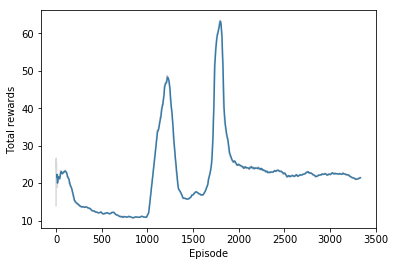

In [16]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

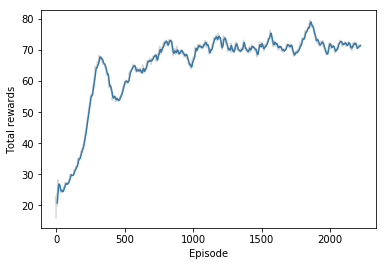

In [18]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

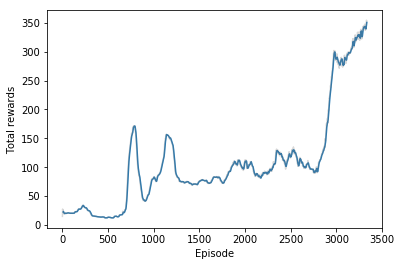

In [27]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

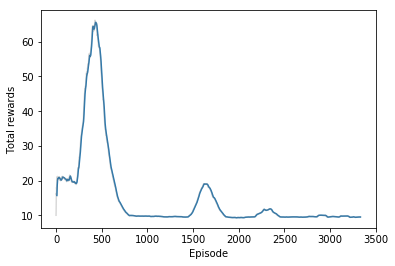

In [24]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

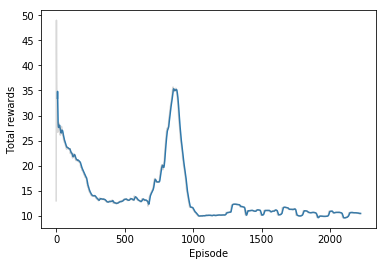

In [26]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

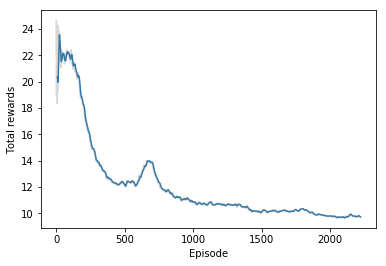

In [16]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

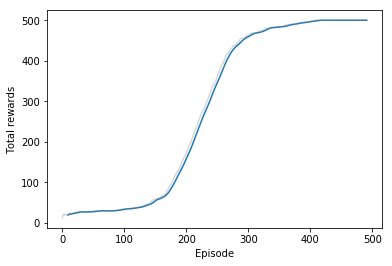

In [62]:
# eps, arr = np.array(episode_rewards_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

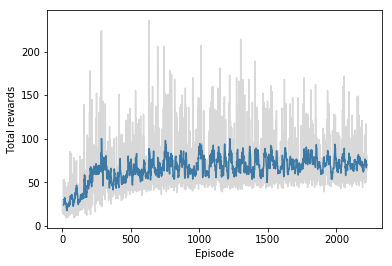

In [19]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

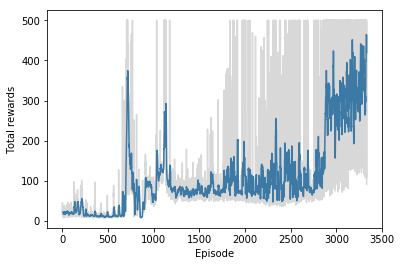

In [29]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

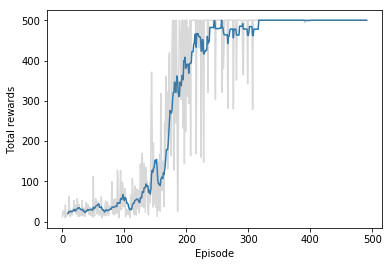

In [63]:
# eps, arr = np.array(rewards_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('Total rewards')

In [19]:
eps, arr = np.array(gloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

In [ ]:
eps, arr = np.array(dloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [36]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.